Loading data...
Data loaded: 502523 claims, 100000 patients, 2000 providers
Preprocessing data...
Preparing features...
Training data shape: (402018, 13)
Test data shape: (100505, 13)
Fraud rate: 0.0300
Training models...
Training xgb...
Training lgbm...
[LightGBM] [Info] Number of positive: 12058, number of negative: 389960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 402018, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Evaluating models...

Ensem

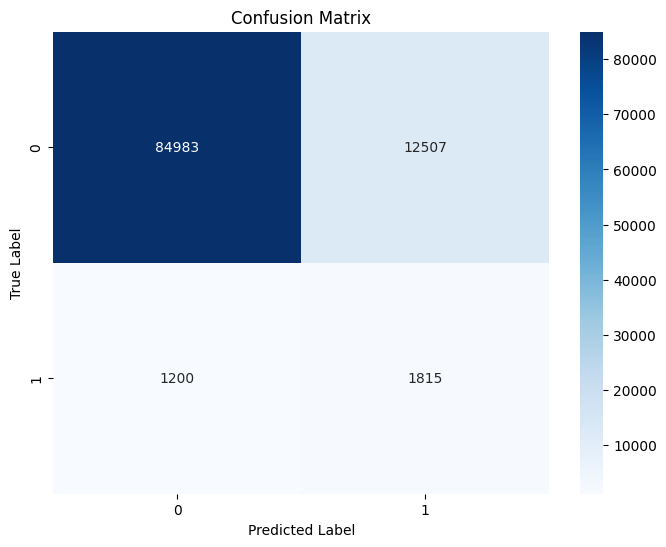

Model saved to simple_fraud_detection_model.pkl
Sample predictions: [0.41785304 0.51649991 0.41996442 0.38544536 0.39912008]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, f1_score, 
                            confusion_matrix, classification_report)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

class SimpleFraudDetector:
    def __init__(self, n_peers=20, similarity_threshold=0.7):
        self.n_peers = n_peers
        self.similarity_threshold = similarity_threshold
        self.procedure_encoder = LabelEncoder()
        self.diagnosis_encoder = LabelEncoder()
        self.specialty_encoder = LabelEncoder()
        self.gender_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.provider_embeddings = None
        self.provider_ids = None
        
        self.models = {
            'isolation_forest': IsolationForest(
                contamination=0.03, 
                random_state=42,
                n_estimators=100
            ),
            'xgb': XGBClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                scale_pos_weight=10,
                eval_metric='logloss',
                use_label_encoder=False
            ),
            'lgbm': LGBMClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                class_weight='balanced'
            )
        }
        
    def preprocess_data(self, claims_df, providers_df, patients_df):
        claims = claims_df.copy()
        claims['procedure_code'] = claims['procedure_code'].fillna('UNKNOWN')
        claims['diagnosis_code'] = claims['diagnosis_code'].fillna('UNKNOWN')
        claims['procedure_code_encoded'] = self.procedure_encoder.fit_transform(claims['procedure_code'])
        claims['diagnosis_code_encoded'] = self.diagnosis_encoder.fit_transform(claims['diagnosis_code'])
        claims['gender_encoded'] = self.gender_encoder.fit_transform(claims['gender'])
        
        claims['claim_start_date'] = pd.to_datetime(claims['claim_start_date'])
        claims['claim_thru_date'] = pd.to_datetime(claims['claim_thru_date'])
        claims['claim_duration'] = (claims['claim_thru_date'] - claims['claim_start_date']).dt.days + 1
        
        providers = providers_df.copy()
        providers['specialty_encoded'] = self.specialty_encoder.fit_transform(providers['specialty'])
        
        patients = patients_df.copy()
        patients['gender_encoded'] = self.gender_encoder.fit_transform(patients['gender'])
        
        if 'provider_id' in patients.columns:
            patients = patients.drop(columns=['provider_id'])
        
        return claims, providers, patients
    
    def create_provider_features(self, claims, providers):
        provider_features = []
        
        for provider_id in providers['provider_id'].unique():
            provider_claims = claims[claims['provider_id'] == provider_id]
            
            if len(provider_claims) == 0:
                continue
                
            features = [
                provider_claims['claim_amount'].mean(),
                provider_claims['claim_amount'].std(),
                provider_claims['length_of_stay'].mean(),
                provider_claims['patient_age'].mean(),
                len(provider_claims),
                provider_claims['procedure_code_encoded'].nunique(),
                provider_claims['diagnosis_code_encoded'].nunique()
            ]
            
            provider_features.append([provider_id] + features)
        
        provider_features_df = pd.DataFrame(
            provider_features, 
            columns=['provider_id', 'avg_claim_amount', 'std_claim_amount', 
                    'avg_length_stay', 'avg_patient_age', 'total_claims',
                    'unique_procedures', 'unique_diagnoses']
        )
        
        return provider_features_df
    
    def find_similar_providers(self, target_provider_id, provider_features_df):
        if self.provider_embeddings is None:
            feature_cols = ['avg_claim_amount', 'std_claim_amount', 'avg_length_stay', 
                           'avg_patient_age', 'total_claims', 'unique_procedures', 'unique_diagnoses']
            self.provider_embeddings = provider_features_df[feature_cols].values
            self.provider_ids = provider_features_df['provider_id'].values
        
        target_idx = np.where(self.provider_ids == target_provider_id)[0]
        if len(target_idx) == 0:
            return []
            
        target_embedding = self.provider_embeddings[target_idx[0]].reshape(1, -1)
        
        similarities = cosine_similarity(target_embedding, self.provider_embeddings)[0]
        
        similar_providers = []
        for idx, similarity in enumerate(similarities):
            if (self.provider_ids[idx] != target_provider_id and 
                similarity > self.similarity_threshold):
                similar_providers.append((self.provider_ids[idx], similarity))
                if len(similar_providers) >= self.n_peers:
                    break
        
        return similar_providers
    
    def prepare_features(self, claims, providers, patients):
        data = claims.merge(patients, on='patient_id', how='left')
        data = data.merge(providers, on='provider_id', how='left')
        
        data['comorbidity_count'] = data['comorbidity_count'].fillna(0)
        data['age'] = data['age'].fillna(data['patient_age'])
        
        provider_features_df = self.create_provider_features(claims, providers)
        
        features = []
        labels = []
        
        for _, claim in data.iterrows():
            claim_features = [
                claim['claim_amount'],
                claim['length_of_stay'],
                claim['patient_age'],
                claim['claim_duration'],
                claim['procedure_code_encoded'],
                claim['diagnosis_code_encoded'],
                claim['gender_encoded_x'],
                claim['comorbidity_count'],
                claim['fraud_tendency'] if 'fraud_tendency' in claim else 0
            ]
            
            similar_providers = self.find_similar_providers(claim['provider_id'], provider_features_df)
            
            if similar_providers:
                peer_ids = [p[0] for p in similar_providers]
                peer_claims = claims[claims['provider_id'].isin(peer_ids)]
                
                peer_stats = [
                    peer_claims['claim_amount'].mean(),
                    peer_claims['claim_amount'].std(),
                    peer_claims['length_of_stay'].mean(),
                    len(peer_claims)
                ]
            else:
                peer_stats = [0, 0, 0, 0]
            
            features.append(claim_features + peer_stats)
            labels.append(claim['is_fraud'])
        
        features_scaled = self.scaler.fit_transform(features)
        
        return np.array(features_scaled), np.array(labels)
    
    def train(self, claims_df, providers_df, patients_df, test_size=0.2):
        print("Preprocessing data...")
        claims, providers, patients = self.preprocess_data(claims_df, providers_df, patients_df)
        
        print("Preparing features...")
        X, y = self.prepare_features(claims, providers, patients)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Test data shape: {X_test.shape}")
        print(f"Fraud rate: {y_train.mean():.4f}")
        
        print("Training models...")
        self.models['isolation_forest'].fit(X_train)
        
        for name, model in self.models.items():
            if name != 'isolation_forest':
                print(f"Training {name}...")
                model.fit(X_train, y_train)
        
        print("Evaluating models...")
        self.evaluate(X_test, y_test)
        
        return X_test, y_test
    
    def evaluate(self, X_test, y_test):

        if_scores = self.models['isolation_forest'].decision_function(X_test)
        if_scores = (if_scores - if_scores.min()) / (if_scores.max() - if_scores.min() + 1e-8)
        
        xgb_proba = self.models['xgb'].predict_proba(X_test)[:, 1]
        lgbm_proba = self.models['lgbm'].predict_proba(X_test)[:, 1]
        
        ensemble_proba = 0.3 * if_scores + 0.4 * xgb_proba + 0.3 * lgbm_proba
        ensemble_pred = (ensemble_proba >= 0.5).astype(int)
        
        auc = roc_auc_score(y_test, ensemble_proba)
        f1 = f1_score(y_test, ensemble_pred)
        
        print(f"\nEnsemble Model Performance:")
        print(f"AUC-ROC: {auc:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, ensemble_pred))
        
        cm = confusion_matrix(y_test, ensemble_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def predict(self, X):
        if_scores = self.models['isolation_forest'].decision_function(X)
        if_scores = (if_scores - if_scores.min()) / (if_scores.max() - if_scores.min() + 1e-8)
        
        xgb_proba = self.models['xgb'].predict_proba(X)[:, 1]
        lgbm_proba = self.models['lgbm'].predict_proba(X)[:, 1]
        
        ensemble_proba = 0.3 * if_scores + 0.4 * xgb_proba + 0.3 * lgbm_proba
        
        return ensemble_proba
    
    def save_model(self, filepath):
        model_data = {
            'models': self.models,
            'scaler': self.scaler,
            'encoders': {
                'procedure': self.procedure_encoder,
                'diagnosis': self.diagnosis_encoder,
                'specialty': self.specialty_encoder,
                'gender': self.gender_encoder
            },
            'provider_embeddings': self.provider_embeddings,
            'provider_ids': self.provider_ids
        }
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        model_data = joblib.load(filepath)
        self.models = model_data['models']
        self.scaler = model_data['scaler']
        self.procedure_encoder = model_data['encoders']['procedure']
        self.diagnosis_encoder = model_data['encoders']['diagnosis']
        self.specialty_encoder = model_data['encoders']['specialty']
        self.gender_encoder = model_data['encoders']['gender']
        self.provider_embeddings = model_data['provider_embeddings']
        self.provider_ids = model_data['provider_ids']
        print(f"Model loaded from {filepath}")

def main():
    print("Loading data...")
    claims = pd.read_csv('enhanced_medicare_data_claims.csv')
    patients = pd.read_csv('enhanced_medicare_data_patients.csv')
    providers = pd.read_csv('enhanced_medicare_data_providers.csv')
    
    print(f"Data loaded: {len(claims)} claims, {len(patients)} patients, {len(providers)} providers")
    
    detector = SimpleFraudDetector(n_peers=15, similarity_threshold=0.6)
    X_test, y_test = detector.train(claims, providers, patients, test_size=0.2)
    
    detector.save_model('simple_fraud_detection_model.pkl')
    
    predictions = detector.predict(X_test)
    print(f"Sample predictions: {predictions[:5]}")

if __name__ == "__main__":
    main()   